<a href="https://colab.research.google.com/github/Lakshman511/EVA4/blob/master/S10/EVA04_s10_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

cloning  github repository and adding path to our system

In [10]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [12]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [13]:
print(mu,std)

[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import sys
sys.path.append("/content/drive/My Drive/myLibrary")

In [0]:
import numpy as np
from eva4albumentations import Albumentations

In [0]:
nms=[mu,std]

In [0]:
a=50

In [0]:
train_transforms=Albumentations(nms,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(a,a,a),cutout=(3,))

In [0]:
test_transforms=Albumentations(nms)

# Dataset and Creating Train/Test Split

In [20]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [22]:
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

1.6210897 -1.9892128


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
channel_stdevs=std
channel_means=mu

torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


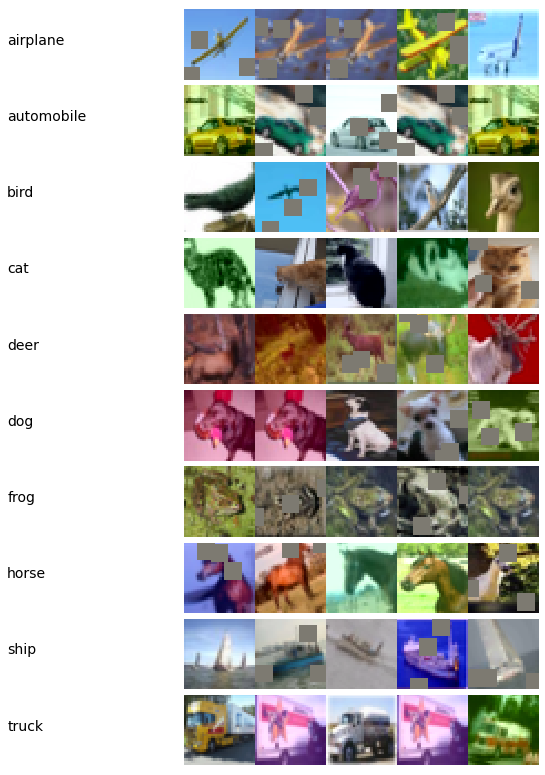

In [24]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model

## Target
1. Less than 7000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 6%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

# Model Creation

We will be creating Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4.

In [0]:
import eva4models

In [0]:
import torch

In [0]:
model=eva4models.ResNet18()

In [0]:
model.device="cuda"

In [29]:
model.to(model.device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [30]:
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



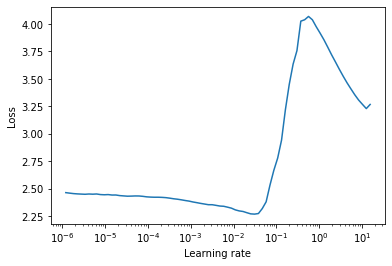

In [31]:
# LR finder fast ai approach
from eva4LRFinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from eva4misclassifiedimages import StatsManager

In [0]:
statsmanager=StatsManager()

In [0]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 2, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)

In [36]:
model.gotrain(optimizer,train_loader,test_loader,EPOCHS,"/content/drive/My Drive",statsmanager,scheduler,False,L1lambda)


In scheduler step with loss of  1.0982184064865113
Validation loss decreased (100000.000000 --> 1.098218).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0098, Accuracy: 55.08%; Test set: Average loss: 1.0982, Accuracy: 61.50%
Learning Rate = 0.030903



In scheduler step with loss of  0.7860288749694824
Validation loss decreased (1.098218 --> 0.786029).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0079, Accuracy: 64.77%; Test set: Average loss: 0.7860, Accuracy: 72.80%
Learning Rate = 0.030903



In scheduler step with loss of  0.7441110004425049
Validation loss decreased (0.786029 --> 0.744111).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0067, Accuracy: 70.35%; Test set: Average loss: 0.7441, Accuracy: 74.73%
Learning Rate = 0.030903



In scheduler step with loss of  0.7111066112518311
Validation loss decreased (0.744111 --> 0.711107).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0059, Accuracy: 73.71%; Test set: Average loss: 0.7111, Accuracy: 75.46%
Learning Rate = 0.030903



In scheduler step with loss of  0.6355459098815918
Validation loss decreased (0.711107 --> 0.635546).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0053, Accuracy: 76.33%; Test set: Average loss: 0.6355, Accuracy: 78.73%
Learning Rate = 0.030903



In scheduler step with loss of  0.5824828601837159
Validation loss decreased (0.635546 --> 0.582483).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0048, Accuracy: 78.54%; Test set: Average loss: 0.5825, Accuracy: 80.17%
Learning Rate = 0.030903



In scheduler step with loss of  0.49205104732513427
Validation loss decreased (0.582483 --> 0.492051).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0045, Accuracy: 80.06%; Test set: Average loss: 0.4921, Accuracy: 83.51%
Learning Rate = 0.030903



In scheduler step with loss of  0.5422394337654114
Epoch: 8, Train set: Average loss: 0.0042, Accuracy: 81.38%; Test set: Average loss: 0.5422, Accuracy: 82.25%
Learning Rate = 0.030903



In scheduler step with loss of  0.5196560355186463
Epoch: 9, Train set: Average loss: 0.0039, Accuracy: 82.79%; Test set: Average loss: 0.5197, Accuracy: 82.86%
Learning Rate = 0.030903



In scheduler step with loss of  0.4762763369083405
Validation loss decreased (0.492051 --> 0.476276).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0036, Accuracy: 83.76%; Test set: Average loss: 0.4763, Accuracy: 84.17%
Learning Rate = 0.030903



In scheduler step with loss of  0.4538588472366333
Validation loss decreased (0.476276 --> 0.453859).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0034, Accuracy: 84.76%; Test set: Average loss: 0.4539, Accuracy: 85.19%
Learning Rate = 0.030903



In scheduler step with loss of  0.5081989935398101
Epoch: 12, Train set: Average loss: 0.0033, Accuracy: 85.58%; Test set: Average loss: 0.5082, Accuracy: 83.44%
Learning Rate = 0.030903



In scheduler step with loss of  0.4028572712421417
Validation loss decreased (0.453859 --> 0.402857).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0031, Accuracy: 86.33%; Test set: Average loss: 0.4029, Accuracy: 86.75%
Learning Rate = 0.030903



In scheduler step with loss of  0.3929224087715149
Validation loss decreased (0.402857 --> 0.392922).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0029, Accuracy: 86.95%; Test set: Average loss: 0.3929, Accuracy: 86.92%
Learning Rate = 0.030903



In scheduler step with loss of  0.3949067907333374
Epoch: 15, Train set: Average loss: 0.0028, Accuracy: 87.70%; Test set: Average loss: 0.3949, Accuracy: 87.19%
Learning Rate = 0.030903



In scheduler step with loss of  0.5060249576568604
Epoch: 16, Train set: Average loss: 0.0026, Accuracy: 88.13%; Test set: Average loss: 0.5060, Accuracy: 84.46%
Learning Rate = 0.030903



In scheduler step with loss of  0.367419618844986
Validation loss decreased (0.392922 --> 0.367420).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0025, Accuracy: 88.72%; Test set: Average loss: 0.3674, Accuracy: 87.87%
Learning Rate = 0.030903



In scheduler step with loss of  0.40003973541259763
Epoch: 18, Train set: Average loss: 0.0024, Accuracy: 89.44%; Test set: Average loss: 0.4000, Accuracy: 87.13%
Learning Rate = 0.030903



In scheduler step with loss of  0.402649430513382
Epoch: 19, Train set: Average loss: 0.0023, Accuracy: 89.57%; Test set: Average loss: 0.4026, Accuracy: 87.39%
Learning Rate = 0.030903



In scheduler step with loss of  0.367458469581604
Epoch    20: reducing learning rate of group 0 to 3.0903e-03.
Epoch: 20, Train set: Average loss: 0.0022, Accuracy: 90.17%; Test set: Average loss: 0.3675, Accuracy: 88.13%
Learning Rate = 0.003090



In scheduler step with loss of  0.28795216054916384
Validation loss decreased (0.367420 --> 0.287952).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0016, Accuracy: 92.86%; Test set: Average loss: 0.2880, Accuracy: 90.52%
Learning Rate = 0.003090



In scheduler step with loss of  0.28336775493621824
Validation loss decreased (0.287952 --> 0.283368).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0014, Accuracy: 93.92%; Test set: Average loss: 0.2834, Accuracy: 90.96%
Learning Rate = 0.003090



In scheduler step with loss of  0.2752043578147888
Validation loss decreased (0.283368 --> 0.275204).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0014, Accuracy: 94.02%; Test set: Average loss: 0.2752, Accuracy: 90.98%
Learning Rate = 0.003090



In scheduler step with loss of  0.27980310888290405
Epoch: 24, Train set: Average loss: 0.0013, Accuracy: 94.40%; Test set: Average loss: 0.2798, Accuracy: 91.29%
Learning Rate = 0.003090



In scheduler step with loss of  0.27629215621948244
Epoch: 25, Train set: Average loss: 0.0012, Accuracy: 94.79%; Test set: Average loss: 0.2763, Accuracy: 91.08%
Learning Rate = 0.003090



In scheduler step with loss of  0.2761675154209137
Epoch    26: reducing learning rate of group 0 to 3.0903e-04.
Epoch: 26, Train set: Average loss: 0.0012, Accuracy: 94.86%; Test set: Average loss: 0.2762, Accuracy: 91.42%
Learning Rate = 0.000309



In scheduler step with loss of  0.2740383162021637
Validation loss decreased (0.275204 --> 0.274038).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0011, Accuracy: 95.10%; Test set: Average loss: 0.2740, Accuracy: 91.35%
Learning Rate = 0.000309



In scheduler step with loss of  0.2712056883096695
Validation loss decreased (0.274038 --> 0.271206).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0011, Accuracy: 95.04%; Test set: Average loss: 0.2712, Accuracy: 91.47%
Learning Rate = 0.000309



In scheduler step with loss of  0.27047431688308715
Validation loss decreased (0.271206 --> 0.270474).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0011, Accuracy: 95.20%; Test set: Average loss: 0.2705, Accuracy: 91.57%
Learning Rate = 0.000309



In scheduler step with loss of  0.27006915225982664
Validation loss decreased (0.270474 --> 0.270069).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0011, Accuracy: 95.27%; Test set: Average loss: 0.2701, Accuracy: 91.46%
Learning Rate = 0.000309



In scheduler step with loss of  0.27039462070465087
Epoch: 31, Train set: Average loss: 0.0011, Accuracy: 95.37%; Test set: Average loss: 0.2704, Accuracy: 91.53%
Learning Rate = 0.000309



In scheduler step with loss of  0.2691835844039917
Validation loss decreased (0.270069 --> 0.269184).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0011, Accuracy: 95.35%; Test set: Average loss: 0.2692, Accuracy: 91.42%
Learning Rate = 0.000309



In scheduler step with loss of  0.26838981771469117
Validation loss decreased (0.269184 --> 0.268390).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0011, Accuracy: 95.35%; Test set: Average loss: 0.2684, Accuracy: 91.41%
Learning Rate = 0.000309



In scheduler step with loss of  0.2708382750034332
Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 95.27%; Test set: Average loss: 0.2708, Accuracy: 91.53%
Learning Rate = 0.000309



In scheduler step with loss of  0.2712565496444702
Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 95.37%; Test set: Average loss: 0.2713, Accuracy: 91.47%
Learning Rate = 0.000309



In scheduler step with loss of  0.26775915813446044
Validation loss decreased (0.268390 --> 0.267759).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0011, Accuracy: 95.41%; Test set: Average loss: 0.2678, Accuracy: 91.59%
Learning Rate = 0.000309



In scheduler step with loss of  0.27041342382431033
Epoch: 37, Train set: Average loss: 0.0010, Accuracy: 95.49%; Test set: Average loss: 0.2704, Accuracy: 91.48%
Learning Rate = 0.000309



In scheduler step with loss of  0.2697140944957733
Epoch: 38, Train set: Average loss: 0.0011, Accuracy: 95.28%; Test set: Average loss: 0.2697, Accuracy: 91.52%
Learning Rate = 0.000309



In scheduler step with loss of  0.2677471124649048
Epoch    39: reducing learning rate of group 0 to 3.0903e-05.
Validation loss decreased (0.267759 --> 0.267747).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0011, Accuracy: 95.39%; Test set: Average loss: 0.2677, Accuracy: 91.55%
Learning Rate = 0.000031



In scheduler step with loss of  0.2684433135986328
Epoch: 40, Train set: Average loss: 0.0010, Accuracy: 95.42%; Test set: Average loss: 0.2684, Accuracy: 91.54%
Learning Rate = 0.000031



In scheduler step with loss of  0.26689377875328063
Validation loss decreased (0.267747 --> 0.266894).  Saving model ...
Epoch: 41, Train set: Average loss: 0.0011, Accuracy: 95.44%; Test set: Average loss: 0.2669, Accuracy: 91.61%
Learning Rate = 0.000031



In scheduler step with loss of  0.26775762839317324
Epoch: 42, Train set: Average loss: 0.0011, Accuracy: 95.49%; Test set: Average loss: 0.2678, Accuracy: 91.55%
Learning Rate = 0.000031



In scheduler step with loss of  0.2677042471885681
Epoch: 43, Train set: Average loss: 0.0010, Accuracy: 95.46%; Test set: Average loss: 0.2677, Accuracy: 91.66%
Learning Rate = 0.000031



In scheduler step with loss of  0.2684440621852875
Epoch    44: reducing learning rate of group 0 to 3.0903e-06.
Epoch: 44, Train set: Average loss: 0.0010, Accuracy: 95.32%; Test set: Average loss: 0.2684, Accuracy: 91.61%
Learning Rate = 0.000003



In scheduler step with loss of  0.26816624073982237
Epoch: 45, Train set: Average loss: 0.0010, Accuracy: 95.57%; Test set: Average loss: 0.2682, Accuracy: 91.63%
Learning Rate = 0.000003



In scheduler step with loss of  0.2690595326423645
Epoch: 46, Train set: Average loss: 0.0010, Accuracy: 95.46%; Test set: Average loss: 0.2691, Accuracy: 91.60%
Learning Rate = 0.000003



In scheduler step with loss of  0.26802689990997314
Epoch    47: reducing learning rate of group 0 to 3.0903e-07.
Epoch: 47, Train set: Average loss: 0.0011, Accuracy: 95.45%; Test set: Average loss: 0.2680, Accuracy: 91.73%
Learning Rate = 0.000000



In scheduler step with loss of  0.2699823404788971
Epoch: 48, Train set: Average loss: 0.0010, Accuracy: 95.43%; Test set: Average loss: 0.2700, Accuracy: 91.61%
Learning Rate = 0.000000



In scheduler step with loss of  0.26940115661621095
Epoch: 49, Train set: Average loss: 0.0010, Accuracy: 95.55%; Test set: Average loss: 0.2694, Accuracy: 91.60%
Learning Rate = 0.000000



In scheduler step with loss of  0.26807821664810183
Epoch    50: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 50, Train set: Average loss: 0.0010, Accuracy: 95.52%; Test set: Average loss: 0.2681, Accuracy: 91.59%
Learning Rate = 0.000000



## Best Accuracy

In [37]:
print("TEST: ", 100*max(model.stats().test_acc))

TEST:  91.73


In [38]:
print("TRAIN: ", 100*max(model.stats().train_acc))

TRAIN:  95.574


# Conclusions

The results clearly indicate overfitting. This we need to address probably using regulaization or more rigorous augmentation. One issue is the image sizes being too small 32x32 for the resnet18 with a very high receptive field. Probably a simpler model would work better.

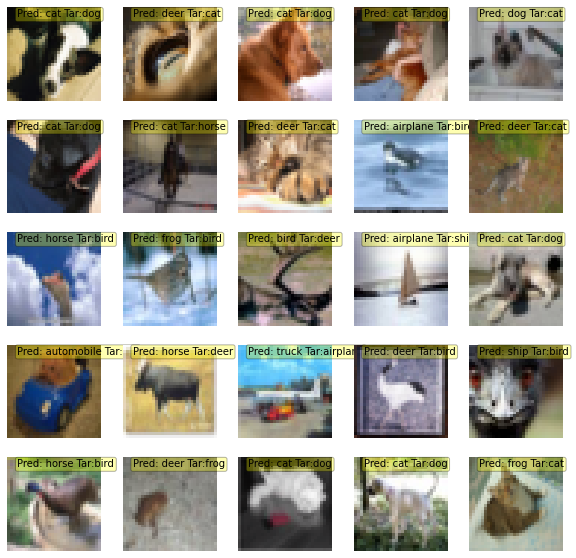

In [39]:
statsmanager.plot_misclassified_25()

# GRAD CAM

In [0]:
target_classes=[]
pred_classes=[]

In [0]:
images=[]

In [0]:
for i in range(1 , 26):
  images.append(statsmanager.data["mis_classified_images"][-i].cpu())
  target_classes.append(statsmanager.data["target"][-i].cpu().item())
  pred_classes.append(statsmanager.data["pred"][-i].cpu().item())

In [43]:
print(target_classes)
print(pred_classes)

[5, 3, 5, 5, 3, 5, 7, 3, 2, 3, 2, 2, 4, 8, 5, 3, 4, 0, 2, 2, 2, 6, 5, 5, 3]
[3, 4, 3, 3, 5, 3, 3, 4, 0, 4, 7, 6, 2, 0, 3, 1, 7, 9, 4, 8, 7, 4, 3, 3, 6]


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


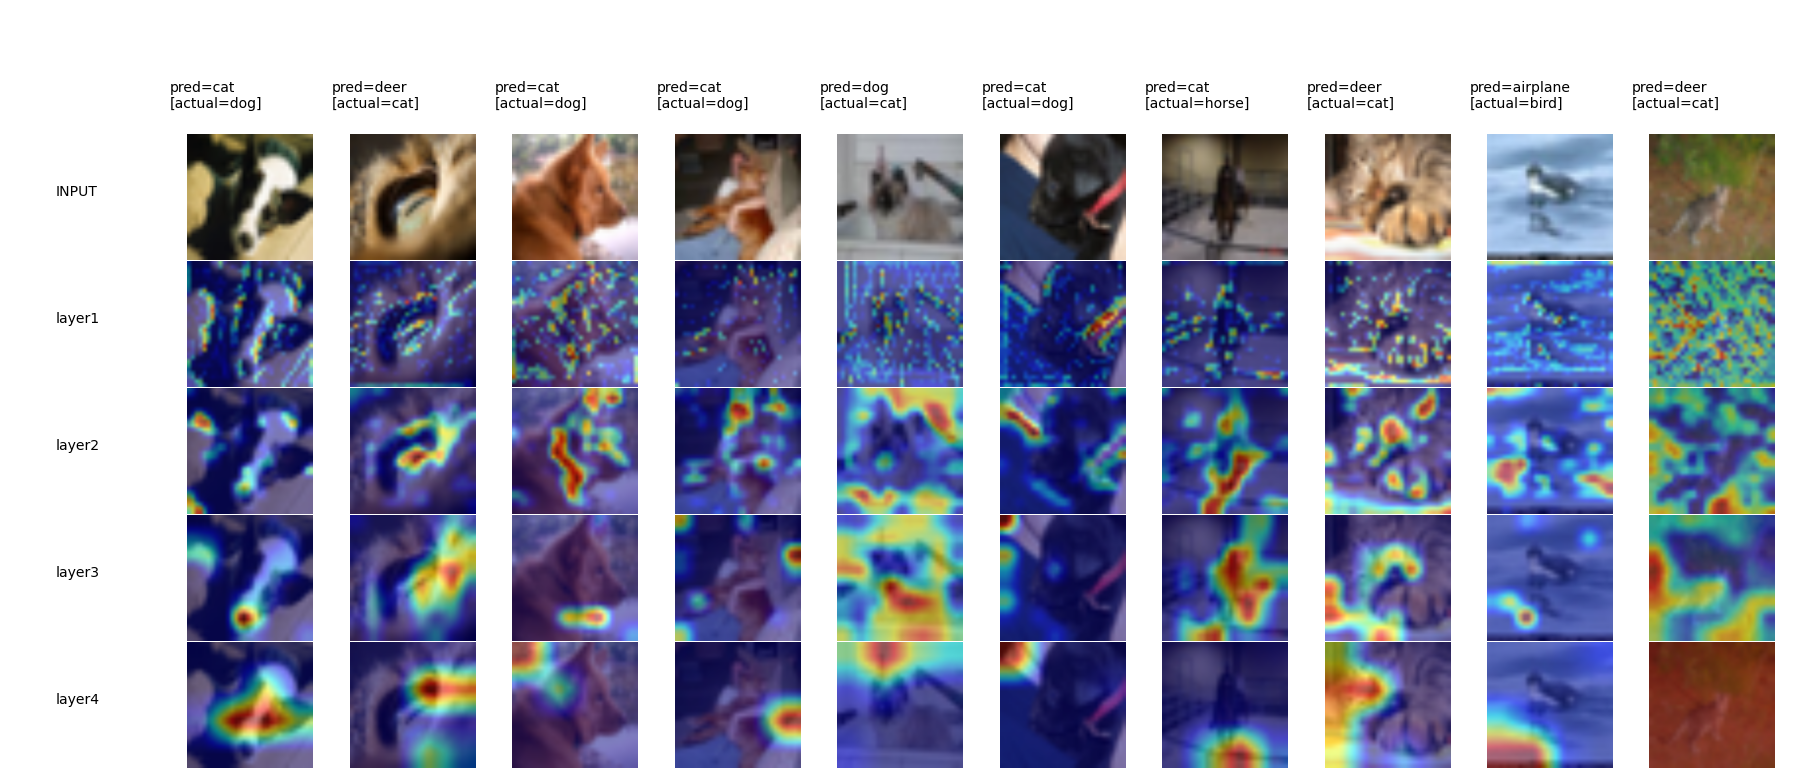

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


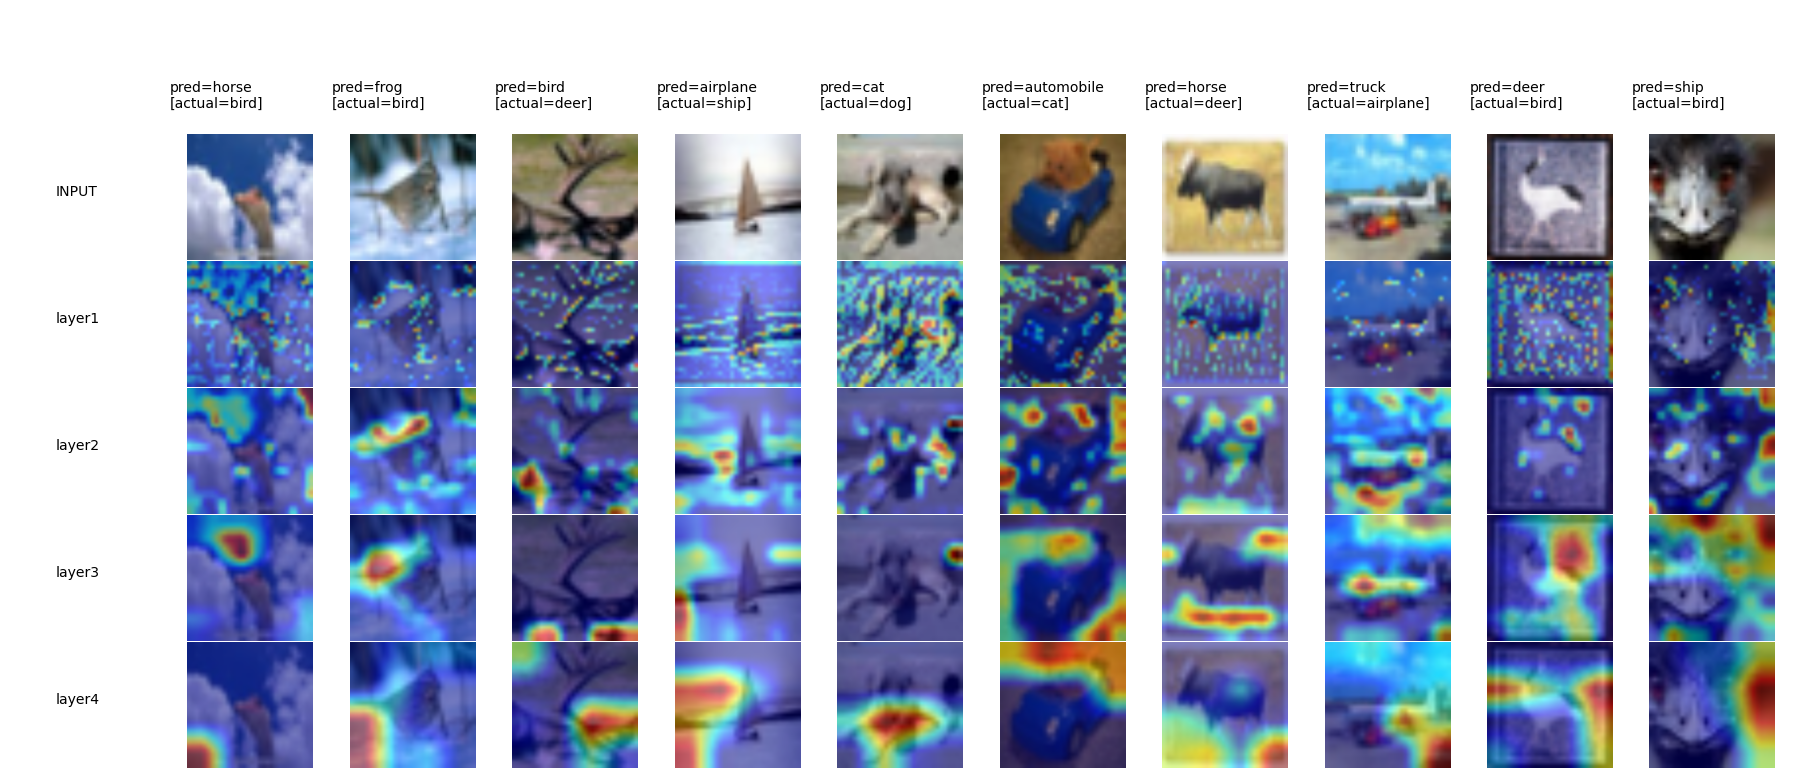

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


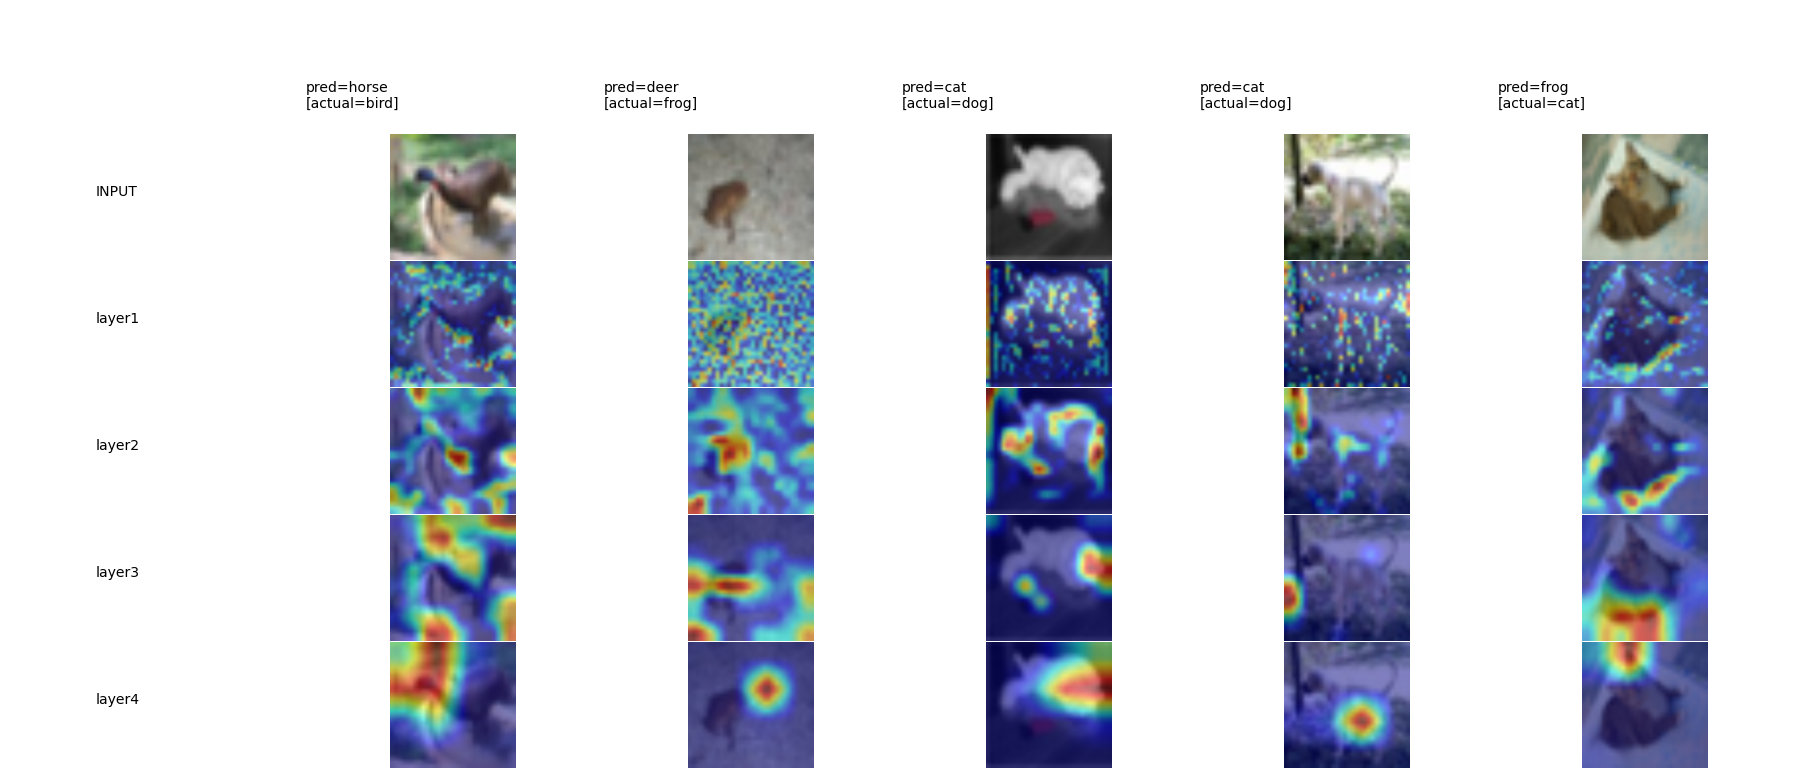

In [44]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)

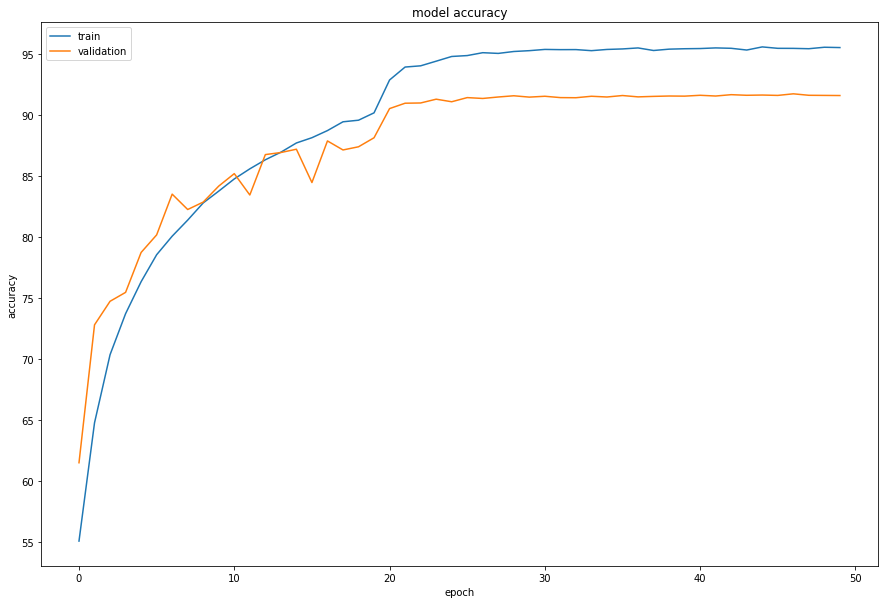

In [45]:
statsmanager.plot_accuracies()

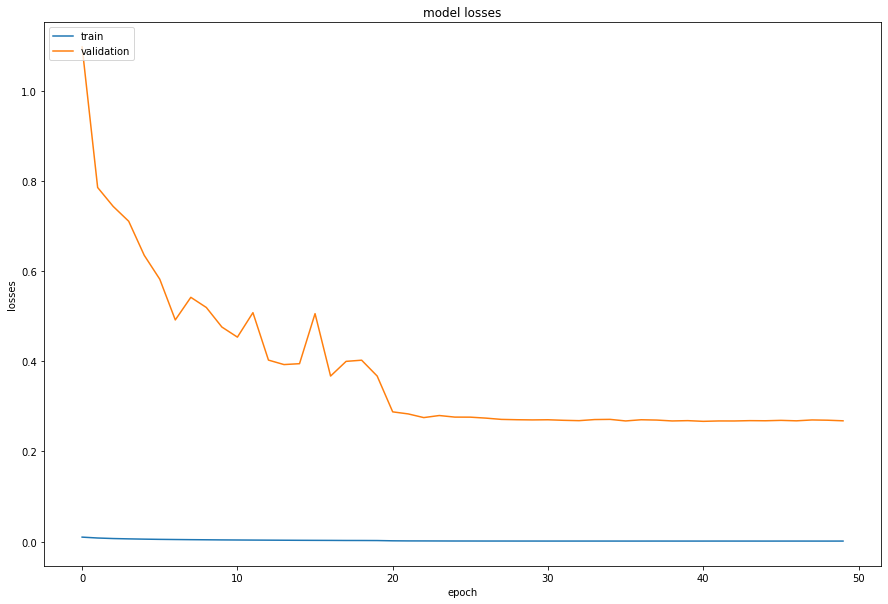

In [46]:
statsmanager.plot_losses()